`cd project/seniorthesis/notebooks`

`conda list PyCO2SYS`

`pip install PyCO2SYS`

`pip install git+https://github.com/jbusecke/cmip6_preprocessing.git`

`mv *.png ../figures`

# PpCO2 for regridded `gn` models

In [1]:
import xarray as xr
import xesmf as xe
from cmip6_preprocessing.preprocessing import combined_preprocessing
import PyCO2SYS as pyco2 # i have to install this package through terminal for it to work
import intake
import matplotlib.pyplot as plt
import numpy as np
import warnings
import gsw
from cmip6_preprocessing.postprocessing import combine_datasets
from cartopy import crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import cmocean
import matplotlib.path as mpath
from cmip6_preprocessing.postprocessing import combine_datasets
from cmip6_preprocessing.postprocessing import merge_variables

In [2]:
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")


In [3]:
variables = ['dissic','talk', 'so', 'thetao', 'fgco2']
z_kwargs = {'consolidated': True, 'use_cftime': True}
query = dict(experiment_id=['historical'], 
             table_id=['Omon'], 
             variable_id=variables,
             grid_label=['gn'],
              source_id=['IPSL-CM6A-LR', 
#                          'MPI-ESM1-2-LR', 
                         'CNRM-ESM2-1', 
                         'CanESM5', 
#                          'MPI-ESM1-2-HR', 
#                          'CMCC-ESM2', 
#                          'GISS-E2-1-G', 
                         'UKESM1-0-LL',
#                          'ACCESS-ESM1-5', 
                         'CanESM5-CanOE' 
#                          'GISS-E2-1-G-CC',
#                          'MPI-ESM-1-2-HAM'
                        ]
            )


cat = col.search(**query)

# print(cat.df['source_id'].unique())
dset_dict_old_gn = cat.to_dataset_dict(zarr_kwargs=z_kwargs, storage_options={'token': 'anon'},
                                preprocess=combined_preprocessing, aggregate=False)

dd_new_gn = merge_variables(dset_dict_old_gn)
# list(dd_new.keys())

temp={}
for name,item in dd_new_gn.items():
    #print(name)
    #print(item.data_vars)
    present = item.data_vars
    if all(i in present for i in variables):
        #print(name)
        temp[name]=item
dd_new_gn2 = temp


def pick_first_member(ds_list, **kwargs):
    return ds_list[0]

dd_new_new_gn = combine_datasets(
    dd_new_gn2,
    pick_first_member,
    match_attrs=['source_id', 'grid_label', 'experiment_id', 'table_id']
)
list(dd_new_new_gn.keys())


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


/srv/conda/envs/notebook/lib/python3.8/site-packages/cmip6_preprocessing/postprocessing.py:138: UserWarning: CMIP.IPSL.IPSL-CM6A-LR.historical.r10i1p1f1.Omon.gn.none failed to combine with :cannot compare cftime.DatetimeGregorian(1850, 1, 16, 12, 0, 0, 0) and cftime.DatetimeProlepticGregorian(1850, 1, 16, 12, 0, 0, 0) (different calendars)
  warnings.warn(f"{cmip6_dataset_id(ds)} failed to combine with :{e}")
/srv/conda/envs/notebook/lib/python3.8/site-packages/cmip6_preprocessing/postprocessing.py:138: UserWarning: CMIP.CNRM-CERFACS.CNRM-ESM2-1.historical.r2i1p1f2.Omon.gn.none failed to combine with :cannot compare cftime.DatetimeGregorian(1850, 1, 16, 12, 0, 0, 0) and cftime.DatetimeProlepticGregorian(1850, 1, 16, 12, 0, 0, 0) (different calendars)
  warnings.warn(f"{cmip6_dataset_id(ds)} failed to combine with :{e}")
/srv/conda/envs/notebook/lib/python3.8/site-packages/cmip6_preprocessing/postprocessing.py:138: UserWarning: CMIP.IPSL.IPSL-CM6A-LR.historical.r2i1p1f1.Omon.gn.none fai

['CanESM5.gn.historical.Omon',
 'IPSL-CM6A-LR.gn.historical.Omon',
 'UKESM1-0-LL.gn.historical.Omon',
 'CNRM-ESM2-1.gn.historical.Omon',
 'CanESM5-CanOE.gn.historical.Omon']

In [4]:
targetgrid_ds = xe.util.grid_global(1.0, 1.0)
# regridder = xe.Regridder(dd_new_new, targetgrid_ds, 'bilinear', 
#                          periodic=True, ignore_degenerate=True)

dd_regrid={}
for name,item in dd_new_new_gn.items():
    regridder = xe.Regridder(item, targetgrid_ds, 'bilinear', 
                         periodic=True, ignore_degenerate=True)
    ds_regridded = regridder(item)
    dd_regrid[name]=ds_regridded
list(dd_regrid.keys())

/srv/conda/envs/notebook/lib/python3.8/site-packages/xesmf/frontend.py:496: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.8/site-packages/xesmf/frontend.py:496: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.8/site-packages/xesmf/frontend.py:496: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.8/site-packages/xesmf/frontend.py:496: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply

['CanESM5.gn.historical.Omon',
 'IPSL-CM6A-LR.gn.historical.Omon',
 'UKESM1-0-LL.gn.historical.Omon',
 'CNRM-ESM2-1.gn.historical.Omon',
 'CanESM5-CanOE.gn.historical.Omon']

In [7]:

def calc_PpCO2_graeme(ds):
    results = pyco2.sys(par1=ds['talk']*1035.0,par2=ds['dissic']*1035.0,par1_type=1,par2_type=2,
                        pressure=0)
    return ds['talk'].copy(data=results['pCO2'])

def calc_PpCO2(ds):
    p = gsw.p_from_z(-1*ds['lev'], ds['y'], geo_strf_dyn_height=0, sea_surface_geopotential=0)
    insitutemp = gsw.t_from_CT(ds['so'], ds['thetao'], p)  # 0 is just a filler rn 
    conversion =  1e6/1035
    results = pyco2.sys(par1=ds.talk*conversion,par2=ds.dissic*conversion,par1_type=1,par2_type=2,
                        pressure_out=0, temperature_out = ds.thetao, pressure = p, 
                        temperature = insitutemp)
    return ds['talk'].copy(data=results['pCO2_out'])

def meridionalsection(ax,da,clims=None,title=None):
    im = ax.pcolormesh(da['y'],da['lev'],da)
    if clims is not None:
        im.set_clim(clims)
#     ax.set_xlim([-80,60])
    ax.set_xlim([20,160])
    ax.invert_yaxis()
    plt.colorbar(im,ax=ax)
    ax.set_title(title)
    
def calc_sigma2(ds):
    return gsw.sigma2(ds['so'],ds['thetao'])

def meridionalsection_with_sigma2(ax,da,sigma2,clims=None,title=None):
    meridionalsection(ax,da,clims)
    ax.contour(da['y'],da['lev'],sigma2,levels=[36,36.4,36.8],colors='w')
    ax.set_title(title)
    
def draw_SOcustom(X,Y,Z,cmap,cbar_label,title,plot_type,**kwargs):
    
    crs_plot = ccrs.SouthPolarStereo()
    crs_source = ccrs.PlateCarree()
    
    fig,ax = plt.subplots(figsize=(10,10),subplot_kw={'projection':crs_plot})
    ax.add_feature(cfeature.LAND,zorder=10,facecolor='darkgray')
    ax.set_extent([-180, 180, -90, -30], crs_source)
    # Compute a circle in axes coordinates, which we can use as a boundary
    # for the map. We can pan/zoom as much as we like - the boundary will be
    # permanently circular.
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    
    ax.gridlines()
    ax.coastlines()
    
    ax.set_title(title,fontsize=14,pad = 20)
    
    if plot_type == 'contourf':
        im = ax.contourf(X,Y,Z,kwargs['clevs'],cmap=cmap,transform=crs_source)
    elif plot_type == 'pcolormesh':
        im = ax.pcolormesh(X,Y,Z,cmap=cmap,transform=crs_source,vmin=kwargs['clims'][0],vmax=kwargs['clims'][1])
    
    cbar = plt.colorbar(im,orientation='horizontal',fraction=0.025,pad=0.05)
    cbar.set_label(cbar_label,fontsize=12)
    
#     plt.show()
    
    return fig,ax

<ipython-input-7-12147306e429>:16: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(da['y'],da['lev'],da)
<ipython-input-7-12147306e429>:16: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(da['y'],da['lev'],da)
<ipython-input-7-12147306e429>:16: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pas

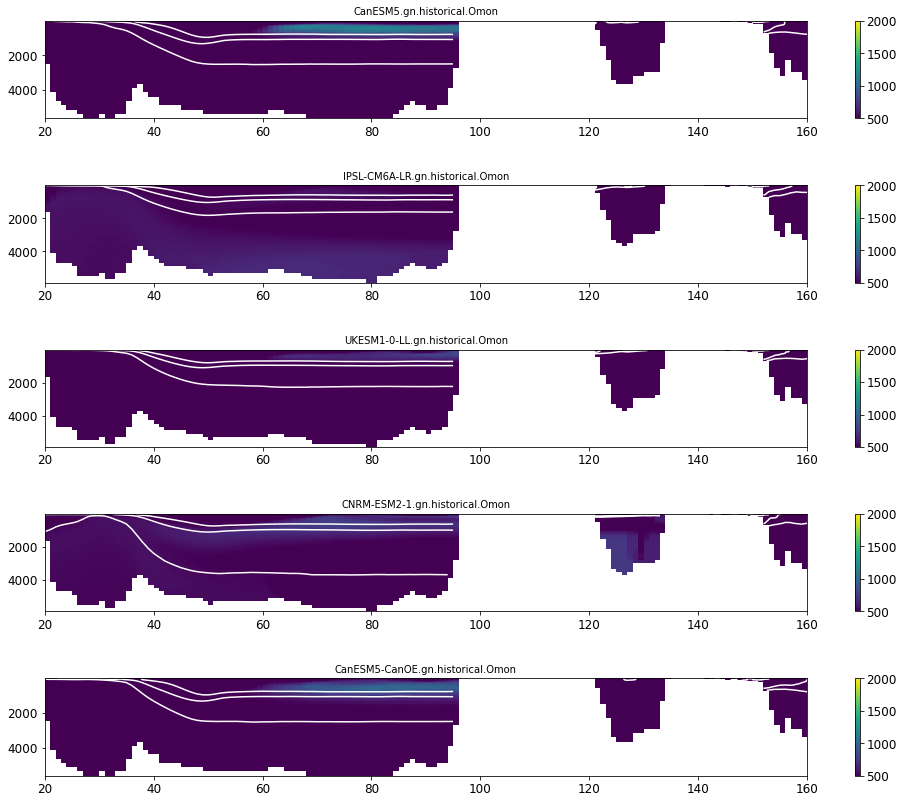

In [16]:
fig_pco2, axarr_pco2 = plt.subplots(nrows = 5, ncols = 1, figsize=[15,12])
fig_pco2.tight_layout(pad = 3.5)
plt.rc('font', size = 12)
plt.rc('axes', titlesize= 10)    
plt.rc('axes', labelsize= 10)
plt.rc('figure', titlesize=14)


ax_idx = 0 # index for your axes array
for name, ds_pco2 in dd_regrid.items():
    ax = axarr_pco2.flat[ax_idx]
    ds_pco2 = ds_pco2.isel(time=0).sel(x=slice(180,200)).mean('x',keep_attrs=True)
    pco2 = calc_PpCO2(ds_pco2)
    sigma2 = calc_sigma2(ds_pco2)
    meridionalsection_with_sigma2(ax,pco2,sigma2, clims=[500,2000],title=name)
    ax_idx += 1 



<ipython-input-7-12147306e429>:16: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(da['y'],da['lev'],da)
/srv/conda/envs/notebook/lib/python3.8/site-packages/matplotlib/contour.py:1430: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/srv/conda/envs/notebook/lib/python3.8/site-packages/matplotlib/contour.py:1431: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
<ipython-input-7-12147306e429>:30: UserWarning: No contour levels were found within the data range.
  ax.contour(da['y'],da['lev'],sigma2,levels=[36,36.4,36.8],colors='w')
<ipython-input-7-12147306e429>:16: MatplotlibDeprecationWarning: shading='flat' when X and Y have the

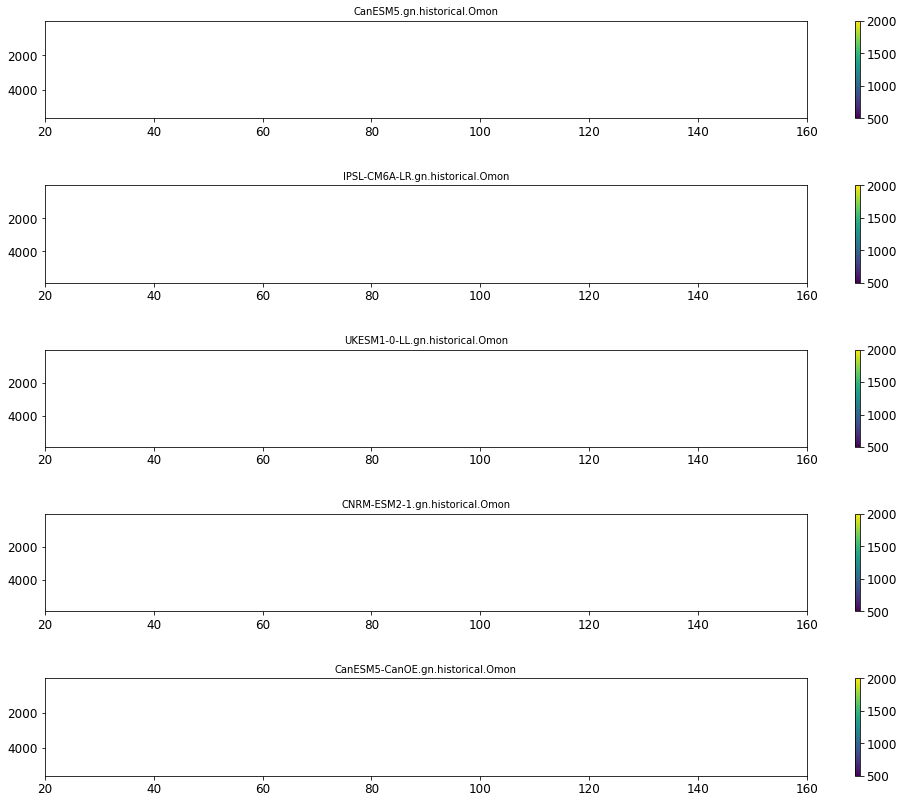

In [17]:
fig_pco2, axarr_pco2 = plt.subplots(nrows = 5, ncols = 1, figsize=[15,12])
fig_pco2.tight_layout(pad = 3.5)
plt.rc('font', size = 12)
plt.rc('axes', titlesize= 10)    
plt.rc('axes', labelsize= 10)
plt.rc('figure', titlesize=14)


ax_idx = 0 # index for your axes array
for name, ds_pco2 in dd_regrid.items():
    ax = axarr_pco2.flat[ax_idx]
    ds_pco2 = ds_pco2.isel(time=0).sel(x=slice(-160,-180)).mean('x',keep_attrs=True)
    pco2 = calc_PpCO2(ds_pco2)
    sigma2 = calc_sigma2(ds_pco2)
    meridionalsection_with_sigma2(ax,pco2,sigma2, clims=[500,2000],title=name)
    ax_idx += 1 

PyCO2SYS error: input shapes cannot be broadcast together.


AttributeError: 'NoneType' object has no attribute 'keys'

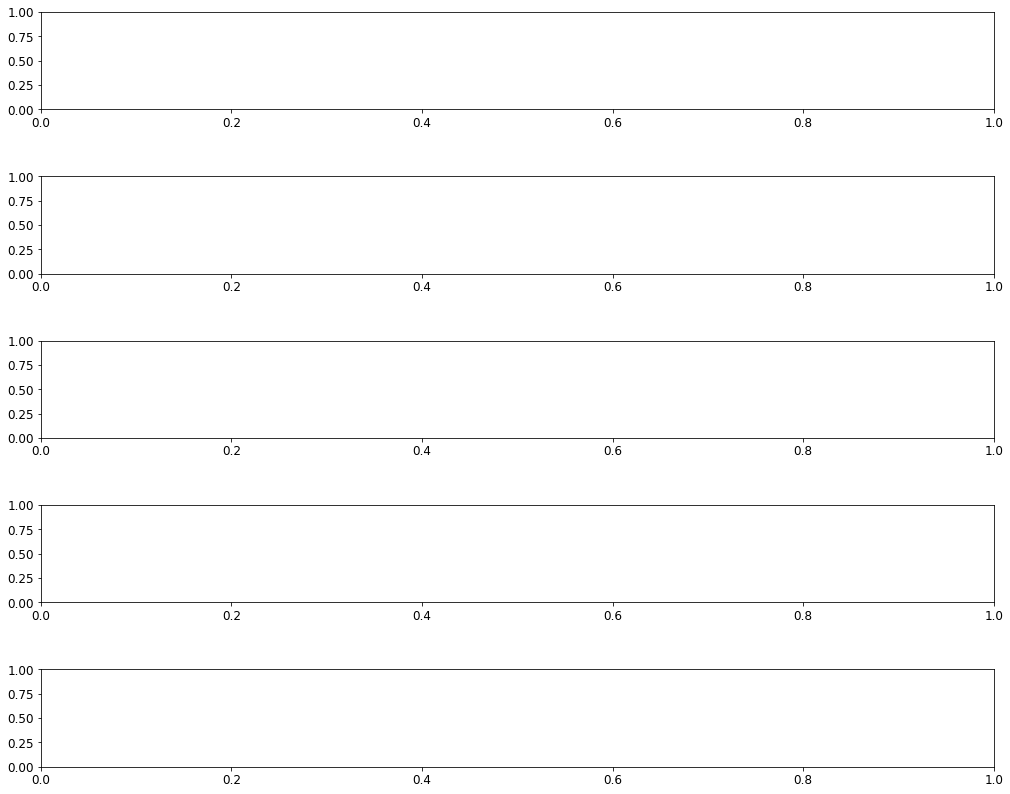

In [18]:
fig_pco2, axarr_pco2 = plt.subplots(nrows = 5, ncols = 1, figsize=[15,12])
fig_pco2.tight_layout(pad = 3.5)
plt.rc('font', size = 12)
plt.rc('axes', titlesize= 10)    
plt.rc('axes', labelsize= 10)
plt.rc('figure', titlesize=14)


ax_idx = 0 # index for your axes array
for name, ds_pco2 in dd_new_new_gn.items():
    ax = axarr_pco2.flat[ax_idx]
    ds_pco2 = ds_pco2.isel(time=0).sel(x=slice(-160,-180)).mean('x',keep_attrs=True)
    pco2 = calc_PpCO2(ds_pco2)
    sigma2 = calc_sigma2(ds_pco2)
    meridionalsection_with_sigma2(ax,pco2,sigma2, clims=[500,2000],title=name)
    ax_idx += 1 

# 'CanESM5.gn.historical.Omon'

In [4]:
a = dd_new_new_gn['CanESM5.gn.historical.Omon'].isel(time = slice(0, 239)).mean('time', keep_attrs=True)
a

<xarray.Dataset>
Dimensions:        (bnds: 2, lev: 45, vertex: 4, x: 360, y: 291)
Coordinates:
  * x              (x) int32 0 1 2 3 4 5 6 7 ... 352 353 354 355 356 357 358 359
  * y              (y) int32 0 1 2 3 4 5 6 7 ... 283 284 285 286 287 288 289 290
    lat            (y, x) float64 dask.array<chunksize=(291, 360), meta=np.ndarray>
  * lev            (lev) float64 3.047 9.454 16.36 ... 5.375e+03 5.625e+03
    lev_bounds     (lev, bnds) float64 dask.array<chunksize=(45, 2), meta=np.ndarray>
    lon            (y, x) float64 dask.array<chunksize=(291, 360), meta=np.ndarray>
    lat_verticies  (y, x, vertex) float64 dask.array<chunksize=(291, 360, 4), meta=np.ndarray>
    lon_verticies  (y, x, vertex) float64 dask.array<chunksize=(291, 360, 4), meta=np.ndarray>
  * bnds           (bnds) int64 0 1
  * vertex         (vertex) int64 0 1 2 3
    lon_bounds     (bnds, y, x) float64 dask.array<chunksize=(1, 291, 360), meta=np.ndarray>
    lat_bounds     (bnds, y, x) float64 dask.array<chunksize=(1, 291, 360), meta=np.ndarray>
Data variables:
    so             (lev, y, x) float32 dask.array<chunksize=(45, 291, 360), meta=np.ndarray>
    dissic         (lev, y, x) float32 dask.array<chunksize=(45, 291, 360), meta=np.ndarray>
    thetao         (lev, y, x) float32 dask.array<chunksize=(45, 291, 360), meta=np.ndarray>
    talk           (lev, y, x) float32 dask.array<chunksize=(45, 291, 360), meta=np.ndarray>
    fgco2          (y, x) float32 dask.array<chunksize=(291, 360), meta=np.ndarray>
Attributes: (12/49)
    CCCma_model_hash:            Unknown
    CCCma_parent_runid:          p2-pictrl
    CCCma_pycmor_hash:           7c87dd3a822d55650b3c17cd65db0ca251282530
    CCCma_runid:                 p2-his09
    Conventions:                 CF-1.7 CMIP-6.2
    YMDH_branch_time_in_child:   1850:01:01:00
    ...                          ...
    table_info:                  Creation Date:(20 February 2019) MD5:374fbe5...
    title:                       CanESM5 output prepared for CMIP6
    variant_label:               r9i1p2f1
    version:                     v20190429
    version_id:                  v20190429
    intake_esm_varname:          None

In [5]:
def meridionalsection(ax,da,clims=None,title=None):
    im = ax.pcolormesh(da['y'],da['lev'],da)
    if clims is not None:
        im.set_clim(clims)
    ax.set_xlim([-80,60])
    ax.invert_yaxis()
    plt.colorbar(im,ax=ax)
    ax.set_title(title)

a['pressure'] = xr.zeros_like(a['thetao'])
p = gsw.p_from_z(-1*a['lev'], a['pressure'], geo_strf_dyn_height=0, sea_surface_geopotential=0)
a['insitutemp'] = gsw.t_from_CT(a['so'], a['thetao'], p) 
conversion =  1e6/1035
results = pyco2.sys(par1=a.talk*conversion,par2=a.dissic*conversion,par1_type=1,par2_type=2,
                pressure_out=0, temperature_out = a.thetao, pressure = p, 
                temperature = a['insitutemp'])
a['pco2_out'] = a['talk'].copy(data=results['pCO2_out'])

a['pco2_out']

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Some input pH values are impossibly high given the input alkalinity;
returning np.nan rather than negative DIC values.
Some input pH values are impossibly high given the input alkalinity;
returning np.nan rather than negative DIC values.


/srv/conda/envs/notebook/lib/python3.8/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
/srv/conda/envs/notebook/lib/python3.8/site-packages/autograd/numpy/numpy_vjps.py:78: RuntimeWarning: divide by zero encountered in true_divide
  defvjp(anp.log,    lambda ans, x : lambda g: g / x)
/srv/conda/envs/notebook/lib/python3.8/site-packages/autograd/numpy/numpy_vjps.py:53: RuntimeWarning: invalid value encountered in multiply
  lambda ans, x, y : unbroadcast_f(y, lambda g: - g * x / y**2))
/srv/conda/envs/notebook/lib/python3.8/site-packages/autograd/numpy/numpy_vjps.py:35: RuntimeWarning: invalid value encountered in multiply
  lambda ans, x, y : unbroadcast_f(y, lambda g: x * g))


Some input pH values are impossibly high given the input alkalinity;
returning np.nan rather than negative DIC values.


/srv/conda/envs/notebook/lib/python3.8/site-packages/PyCO2SYS/buffers/__init__.py:52: RuntimeWarning: invalid value encountered in multiply
  omegaTA = dTA_dPH__TC / (dlnOmegaAr_dCARB * dCARB_dPH__TC)
/srv/conda/envs/notebook/lib/python3.8/site-packages/PyCO2SYS/buffers/__init__.py:67: RuntimeWarning: divide by zero encountered in true_divide
  return dTA_dPH__FC / dTC_dPH__FC
/srv/conda/envs/notebook/lib/python3.8/site-packages/PyCO2SYS/buffers/explicit.py:51: RuntimeWarning: invalid value encountered in true_divide
  return 1 + 2 * (K2 / (K0 * K1)) * TC / pCO2


Some input pH values are impossibly high given the input alkalinity;
returning np.nan rather than negative DIC values.
Some input pH values are impossibly high given the input alkalinity;
returning np.nan rather than negative DIC values.
Some input pH values are impossibly high given the input alkalinity;
returning np.nan rather than negative DIC values.


<xarray.DataArray 'pco2_out' (lev: 45, y: 291, x: 360)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * x        (x) int32 0 1 2 3 4 5 6 7 8 ... 351 352 353 354 355 356 357 358 359
  * y        (y) int32 0 1 2 3 4 5 6 7 8 ... 282 283 284 285 286 287 288 289 290
    lat      (y, x) float64 dask.array<chunksize=(291, 360), meta=np.ndarray>
  * lev      (lev) float64 3.047 9.454 16.36 ... 5.126e+03 5.375e+03 5.625e+03
    lon      (y, x) float64 dask.array<chunksize=(291, 360), meta=np.ndarray>
Attributes:
    cell_measures:  area: areacello volume: volcello
    cell_methods:   area: mean where sea time: mean
    comment:        total alkalinity equivalent concentration (including carb...
    history:        mltby1em3
    long_name:      Total Alkalinity
    original_name:  Alkalini
    standard_name:  sea_water_alkalinity_expressed_as_mole_equivalent
    units:          mol m-3

In [14]:
temp = {}
temp[a.source_id] = a['pco2_out']
temp

{'CanESM5': <xarray.DataArray 'pco2_out' (lev: 45, y: 291, x: 360)>
 array([[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],
 
        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],
 
        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
 ...
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],
 
        [[nan, nan, nan, ..., nan,

# 'IPSL-CM6A-LR.gn.historical.Omon'

In [4]:
b = dd_new_new_gn['IPSL-CM6A-LR.gn.historical.Omon'].isel(time = slice(0, 239)).mean('time', keep_attrs=True)
b

<xarray.Dataset>
Dimensions:        (bnds: 2, lev: 75, vertex: 4, x: 362, y: 332)
Coordinates:
    lat_verticies  (y, x, vertex) float32 dask.array<chunksize=(332, 362, 4), meta=np.ndarray>
    lon_verticies  (y, x, vertex) float32 dask.array<chunksize=(332, 362, 4), meta=np.ndarray>
    lat            (y, x) float32 dask.array<chunksize=(332, 362), meta=np.ndarray>
    lon            (y, x) float32 dask.array<chunksize=(332, 362), meta=np.ndarray>
  * lev            (lev) float32 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
    lev_bounds     (lev, bnds) float32 dask.array<chunksize=(75, 2), meta=np.ndarray>
  * bnds           (bnds) int64 0 1
  * vertex         (vertex) int64 0 1 2 3
  * x              (x) int64 0 1 2 3 4 5 6 7 ... 354 355 356 357 358 359 360 361
  * y              (y) int64 0 1 2 3 4 5 6 7 ... 324 325 326 327 328 329 330 331
    lon_bounds     (bnds, y, x) float32 dask.array<chunksize=(1, 332, 362), meta=np.ndarray>
    lat_bounds     (bnds, y, x) float32 dask.array<chunksize=(1, 332, 362), meta=np.ndarray>
Data variables:
    area           (y, x) float32 dask.array<chunksize=(332, 362), meta=np.ndarray>
    so             (lev, y, x) float32 dask.array<chunksize=(75, 332, 362), meta=np.ndarray>
    dissic         (lev, y, x) float32 dask.array<chunksize=(75, 332, 362), meta=np.ndarray>
    fgco2          (y, x) float32 dask.array<chunksize=(332, 362), meta=np.ndarray>
    thetao         (lev, y, x) float32 dask.array<chunksize=(75, 332, 362), meta=np.ndarray>
    talk           (lev, y, x) float32 dask.array<chunksize=(75, 332, 362), meta=np.ndarray>
Attributes: (12/44)
    CMIP6_CV_version:       cv=6.2.3.5-2-g63b123e
    Conventions:            CF-1.7 CMIP-6.2
    EXPID:                  historical
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    ...                     ...
    sub_experiment:         none
    sub_experiment_id:      none
    table_id:               Omon
    title:                  IPSL-CM6A-LR model output prepared for CMIP6 / CM...
    variant_label:          r29i1p1f1
    intake_esm_varname:     None

In [ ]:
b['pressure'] = xr.zeros_like(b['thetao'])
p = gsw.p_from_z(-1*b['lev'], b['pressure'], geo_strf_dyn_height=0, sea_surface_geopotential=0)
b['insitutemp'] = gsw.t_from_CT(b['so'], b['thetao'], p) 
conversion =  1e6/1035
results = pyco2.sys(par1=b.talk*conversion,par2=b.dissic*conversion,par1_type=1,par2_type=2,
                pressure_out=0, temperature_out = b.thetao, pressure = p, 
                temperature = b['insitutemp'])
b['pco2_out'] = b['talk'].copy(data=results['pCO2_out'])


In [ ]:
temp[b.source_id] = b['pco2_out']
temp

# 'CanESM5-CanOE.gn.historical.Omon'

In [17]:
c = dd_regrid['CanESM5-CanOE.gn.historical.Omon'].isel(time = slice(0, 239)).mean('time', keep_attrs=True)
c

<xarray.Dataset>
Dimensions:     (bnds: 2, lev: 45, vertex: 4, x: 360, y: 180)
Coordinates:
  * lev         (lev) float64 3.047 9.454 16.36 ... 5.375e+03 5.625e+03
    lev_bounds  (lev, bnds) float64 dask.array<chunksize=(45, 2), meta=np.ndarray>
  * bnds        (bnds) int64 0 1
  * vertex      (vertex) int64 0 1 2 3
    lon         (y, x) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
    lat         (y, x) float64 -89.5 -89.5 -89.5 -89.5 ... 89.5 89.5 89.5 89.5
Dimensions without coordinates: x, y
Data variables:
    thetao      (lev, y, x) float64 dask.array<chunksize=(45, 180, 360), meta=np.ndarray>
    so          (lev, y, x) float64 dask.array<chunksize=(45, 180, 360), meta=np.ndarray>
    fgco2       (y, x) float64 dask.array<chunksize=(180, 360), meta=np.ndarray>
    talk        (lev, y, x) float64 dask.array<chunksize=(45, 180, 360), meta=np.ndarray>
    dissic      (lev, y, x) float64 dask.array<chunksize=(45, 180, 360), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

In [ ]:
c['pressure'] = xr.zeros_like(c['thetao'])
p = gsw.p_from_z(-1*c['lev'], c['pressure'], geo_strf_dyn_height=0, sea_surface_geopotential=0)
c['insitutemp'] = gsw.t_from_CT(c['so'], c['thetao'], p) 
conversion =  1e6/1035
results = pyco2.sys(par1=c.talk*conversion,par2=c.dissic*conversion,par1_type=1,par2_type=2,
                pressure_out=0, temperature_out = c.thetao, pressure = p, 
                temperature = c['insitutemp'])
c['pco2_out'] = c['talk'].copy(data=results['pCO2_out'])
c['pco2_out']

# 'UKESM1-0-LL.gn.historical.Omon'

In [18]:
d = dd_regrid['UKESM1-0-LL.gn.historical.Omon'].isel(time = slice(0, 239)).mean('time', keep_attrs=True)
d

<xarray.Dataset>
Dimensions:     (bnds: 2, lev: 75, vertex: 4, x: 360, y: 180)
Coordinates:
  * lev         (lev) float64 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
    lev_bounds  (lev, bnds) float64 dask.array<chunksize=(75, 2), meta=np.ndarray>
  * bnds        (bnds) int64 0 1
  * vertex      (vertex) int64 0 1 2 3
    lon         (y, x) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
    lat         (y, x) float64 -89.5 -89.5 -89.5 -89.5 ... 89.5 89.5 89.5 89.5
Dimensions without coordinates: x, y
Data variables:
    thetao      (lev, y, x) float64 dask.array<chunksize=(75, 180, 360), meta=np.ndarray>
    so          (lev, y, x) float64 dask.array<chunksize=(75, 180, 360), meta=np.ndarray>
    fgco2       (y, x) float64 dask.array<chunksize=(180, 360), meta=np.ndarray>
    dissic      (lev, y, x) float64 dask.array<chunksize=(75, 180, 360), meta=np.ndarray>
    talk        (lev, y, x) float64 dask.array<chunksize=(75, 180, 360), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

In [ ]:
d['pressure'] = xr.zeros_like(d['thetao'])
p = gsw.p_from_z(-1*d['lev'], d['pressure'], geo_strf_dyn_height=0, sea_surface_geopotential=0)
d['insitutemp'] = gsw.t_from_CT(d['so'], d['thetao'], p) 
conversion =  1e6/1035
results = pyco2.sys(par1=d.talk*conversion,par2=d.dissic*conversion,par1_type=1,par2_type=2,
                pressure_out=0, temperature_out = d.thetao, pressure = p, 
                temperature = d['insitutemp'])
d['pco2_out'] = d['talk'].copy(data=results['pCO2_out'])
d['pco2_out']

# 'CNRM-ESM2-1.gn.historical.Omon'

In [19]:
e = dd_regrid['CNRM-ESM2-1.gn.historical.Omon'].isel(time = slice(0, 239)).mean('time', keep_attrs=True)
e

<xarray.Dataset>
Dimensions:     (bnds: 2, lev: 75, vertex: 4, x: 360, y: 180)
Coordinates:
  * lev         (lev) float64 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
  * bnds        (bnds) int64 0 1
  * vertex      (vertex) int64 0 1 2 3
    lev_bounds  (lev, bnds) float64 dask.array<chunksize=(75, 2), meta=np.ndarray>
    lon         (y, x) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
    lat         (y, x) float64 -89.5 -89.5 -89.5 -89.5 ... 89.5 89.5 89.5 89.5
Dimensions without coordinates: x, y
Data variables:
    fgco2       (y, x) float64 dask.array<chunksize=(180, 360), meta=np.ndarray>
    talk        (lev, y, x) float64 dask.array<chunksize=(75, 180, 360), meta=np.ndarray>
    thetao      (lev, y, x) float64 dask.array<chunksize=(75, 180, 360), meta=np.ndarray>
    dissic      (lev, y, x) float64 dask.array<chunksize=(75, 180, 360), meta=np.ndarray>
    so          (lev, y, x) float64 dask.array<chunksize=(75, 180, 360), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

In [ ]:
e['pressure'] = xr.zeros_like(e['thetao'])
p = gsw.p_from_z(-1*e['lev'], e['pressure'], geo_strf_dyn_height=0, sea_surface_geopotential=0)
e['insitutemp'] = gsw.t_from_CT(e['so'], e['thetao'], p) 
conversion =  1e6/1035
results = pyco2.sys(par1=e.talk*conversion,par2=e.dissic*conversion,par1_type=1,par2_type=2,
                pressure_out=0, temperature_out = e.thetao, pressure = p, 
                temperature = e['insitutemp'])
e['pco2_out'] = e['talk'].copy(data=results['pCO2_out'])
e['pco2_out']

In [4]:
targetgrid_ds = xe.util.grid_global(1.0, 1.0)
# regridder = xe.Regridder(dd_new_new, targetgrid_ds, 'bilinear', 
#                          periodic=True, ignore_degenerate=True)

dd_regrid={}
for name,item in dd_new_new_gn.items():
    regridder = xe.Regridder(item, targetgrid_ds, 'bilinear', 
                         periodic=True, ignore_degenerate=True)
    ds_regridded = regridder(item)
    dd_regrid[name]=ds_regridded
list(dd_regrid.keys())

/srv/conda/envs/notebook/lib/python3.8/site-packages/xesmf/frontend.py:496: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.8/site-packages/xesmf/frontend.py:496: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.8/site-packages/xesmf/frontend.py:496: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.8/site-packages/xesmf/frontend.py:496: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply

['IPSL-CM6A-LR.gn.historical.Omon',
 'CanESM5.gn.historical.Omon',
 'UKESM1-0-LL.gn.historical.Omon',
 'CanESM5-CanOE.gn.historical.Omon',
 'CNRM-ESM2-1.gn.historical.Omon']